Encoded X shape: torch.Size([5469691, 384])
Target y shape: torch.Size([5469691])
Epoch 0: Loss = 65.225380
Epoch 50: Loss = 60.480896
Epoch 100: Loss = 53.685677
Epoch 150: Loss = 48.307137
Epoch 200: Loss = 45.589016
Epoch 250: Loss = 44.150208
Epoch 300: Loss = 43.170864
Epoch 350: Loss = 42.464230
Epoch 400: Loss = 41.927540
Epoch 450: Loss = 41.496944
Epoch 0: Loss = 65.426712
Epoch 50: Loss = 63.026245
Epoch 100: Loss = 59.561760
Epoch 150: Loss = 55.309017
Epoch 200: Loss = 51.161846
Epoch 250: Loss = 48.052750
Epoch 300: Loss = 46.120926
Epoch 350: Loss = 44.889896
Epoch 400: Loss = 44.020641
Epoch 450: Loss = 43.359543


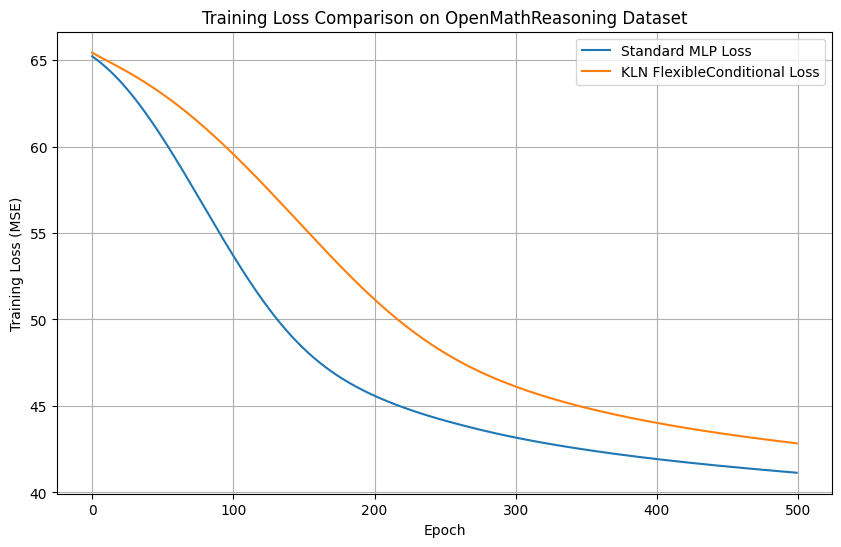

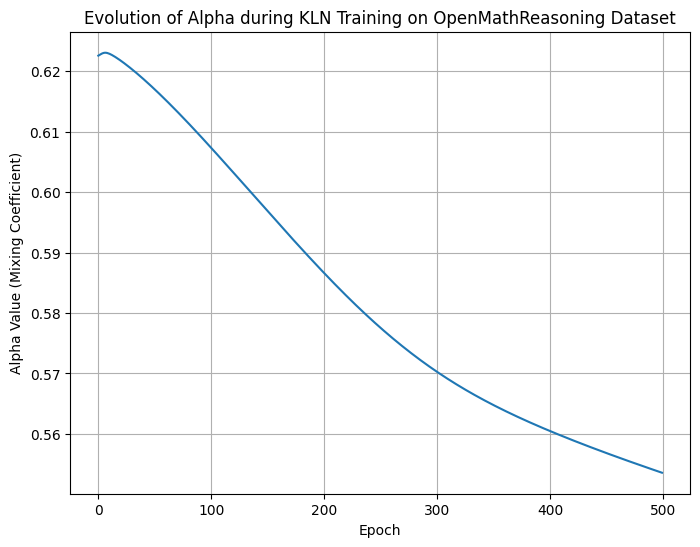

In [10]:
# KLN vs Standard MLP Benchmark on OpenMathReasoning Dataset
from kln import FlexibleConditional, create_flexible_model
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# --- Standard MLP Model ---
class StandardMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(StandardMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# --- KLN Model ---
class KLNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(KLNModel, self).__init__()
        self.model = FlexibleConditional(input_dim, hidden_dim, output_dim)
        self.input_dim = input_dim

    def forward(self, x):
        i = x[:, :self.input_dim // 2]
        j = x[:, self.input_dim // 2:]
        return self.model(i, j)

# --- Load OpenMathReasoning Dataset ---
dataset = load_dataset("nvidia/OpenMathReasoning")

# Load a sentence transformer model
encoder = SentenceTransformer('all-MiniLM-L6-v2')

# Encode questions into dense vectors
questions = []
answers = []

for split in ["cot", "tir", "genselect"]:
    questions += [d['problem'] for d in dataset[split]]
    answers += [d['expected_answer'] for d in dataset[split]]
    
X = torch.tensor(encoder.encode(questions, convert_to_numpy=True), dtype=torch.float32)

# Create numeric targets based on answer length (number of words)
y = torch.tensor([len(ans.split()) for ans in answers], dtype=torch.float32)

print(f"Encoded X shape: {X.shape}")
print(f"Target y shape: {y.shape}")

# --- Train Function ---
def train_model(model, X_train, y_train, epochs=500, lr=5e-4, track_alpha=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    losses = []
    alphas = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X_train).squeeze()
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if track_alpha:
            with torch.no_grad():
                alphas.append(torch.sigmoid(model.model.alpha).item())

        if epoch % 50 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

    if track_alpha:
        return losses, alphas
    else:
        return losses

# --- Train both models ---
input_dim = X.shape[1]
hidden_dim = 64
output_dim = 1

# Standard MLP
standard_model = StandardMLP(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
standard_losses = train_model(standard_model, X, y)

# KLN Model
kln_model = KLNModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
kln_losses, kln_alphas = train_model(kln_model, X, y, track_alpha=True)

# --- Plot Training Losses ---
plt.figure(figsize=(10,6))
plt.plot(standard_losses, label='Standard MLP Loss')
plt.plot(kln_losses, label='KLN FlexibleConditional Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss (MSE)')
plt.title('Training Loss Comparison on OpenMathReasoning Dataset')
plt.legend()
plt.grid(True)
# plt.savefig('figures/openmath_training_loss.png')
plt.show()

# --- Plot Alpha Evolution ---
plt.figure(figsize=(8,6))
plt.plot(kln_alphas)
plt.xlabel('Epoch')
plt.ylabel('Alpha Value (Mixing Coefficient)')
plt.title('Evolution of Alpha during KLN Training on OpenMathReasoning Dataset')
plt.grid(True)
# plt.savefig('figures/openmath_alpha_evolution.png')
plt.show()